In [2]:
import geopandas as gpd
import os
import pandas as pd
import matplotlib.pyplot as plt

os.environ["CONDA_PREFIX"] = "C:/Users/matth/miniconda3/envs/geo_env"
os.environ['GDAL_DATA'] = os.environ['CONDA_PREFIX'] + "/Library/share/gdal"
os.environ['PROJ_LIB'] = os.environ['CONDA_PREFIX'] + '/Library/share'

c_df = gpd.read_file("C:/Users/matth/Downloads/bdline_essh_gb/Data/GB/westminster_const_region.shp")
c_df = c_df.drop(columns=["AREA_CODE", "DESCRIPTIO", "FILE_NAME", "NUMBER", "NUMBER0", "POLYGON_ID", "UNIT_ID", "HECTARES", "AREA", "TYPE_CODE", "DESCRIPT0", "TYPE_COD0", "DESCRIPT1"])
c_df = c_df.set_index("CODE")

In [3]:
STRONG_THRESHOLD = 20
countries = ["England", "Scotland", "Wales"]
polls = {"England":{"Lab": 44.2, "Con": 25.1, "LD": 11.2, "Green": 6.1, "Brexit": 8.4, "other": 5.0},
          "Scotland":{"SNP": 35.1, "Lab": 32.8, "Con": 18.1, "LD": 6.8, "Green": 4.8, "Brexit": 0, "other": 2.4},
          "Wales":{"Lab": 49.5, "Con": 18.6, "PC": 16.3, "LD": 8.1, "Green": 0, "Brexit": 4.1, "other": 3.4}}


results_df = pd.read_csv("2019-results-by-constituency.csv")
results_df["MP"] = results_df["mp_firstname"] + " " + results_df["mp_surname"]
results_df = results_df.drop(columns=["constituency_type", "ons_region_id", "mp_firstname", "mp_surname", "mp_gender", "declaration_time"])
results_df = results_df.rename({"ons_id": "CODE"}, axis=1)
results_df = results_df.set_index("CODE")

df = pd.merge(c_df, results_df, on="CODE")
df = df.drop(columns=["NAME", "dup", "sf", "sdlp", "uup", "alliance"]).set_index("constituency_name")
df = df.rename(columns={"all_other_candidates": "other"})

parties = list(df["first_party"].unique())
party_colors = {"Lab":"darkred", "Con":"dodgerblue", "SNP":"yellow", "PC":"darkgreen", "LD":"orange", "Green":"green", "other":"lightgray", "Brexit":"purple"}
parties.remove("Spk")
parties.append("Brexit")
parties.append("other")

In [4]:
for party in parties:
    df[f"{party}_pc"] = (df[party.lower()] / df["valid_votes"]) * 100

def map_2019():
    ax = df.plot(figsize=(40,40), color="none", edgecolor="none")
    for party in parties:
        df[df["first_party"] == party].plot(color=party_colors[party], ax=ax)
    plt.show()

def strongweak_split(party: str, df, threshold):
    df[f"{party}_STRONG"] = df.apply(lambda row: max(row[f"{party}_pc"]-threshold, 0), axis=1)
    df[f"{party}_WEAK"] = df[f"{party}_pc"] - df[f"{party}_STRONG"]

def get_national_voteshare(df: gpd.GeoDataFrame, col: str):
     return df[[col]].sum().iloc[0] / len(df[[col]])

def new_strongweak_split(old_national_voteshares, polls):
    shares = {}
    for party in polls:
        shares[party] = min(polls[party], old_national_voteshares[party][0]), max(polls[party] - old_national_voteshares[party][0], 0)
    return shares

def predict_country(country: str, df, threshold, polls):
    for party in parties:
        strongweak_split(party, df, threshold)

    country_df = df[df["country_name"] == country].copy(deep=True)

    old_national_voteshares = {}
    for party in parties:
        if party == "Spk":
            continue
        old_national_voteshares[party] = get_national_voteshare(country_df, f"{party}_STRONG"), get_national_voteshare(country_df, f"{party}_WEAK")
    

    new_national_voteshares = new_strongweak_split(old_national_voteshares, polls[country])

    for party in polls[country]:
        if party == "other":
            continue
        country_df[f"{party}_strong_share"] = max(new_national_voteshares[party][0] - old_national_voteshares[party][0], 0) / sum([max(sum(new_national_voteshares[p]) - sum(old_national_voteshares[p]), 0) for p in polls[country] if p != "other"])
        country_df[f"{party}_weak_share"] = max(new_national_voteshares[party][1] - old_national_voteshares[party][1], 0) / sum([max(sum(new_national_voteshares[p]) - sum(old_national_voteshares[p]), 0) for p in polls[country] if p != "other"])

    declining_parties = [party for party in polls[country] if sum(new_national_voteshares[party]) < sum(old_national_voteshares[party])]

    for party in parties:
        if party not in polls[country]:
            country_df[f"{party}_STRONG_NEW"] = country_df[f"{party}_STRONG"]
            country_df[f"{party}_WEAK_NEW"] = country_df[f"{party}_WEAK"]
        if party in declining_parties:
            if old_national_voteshares[party][0] == 0:
                country_df[f"{party}_STRONG_NEW"] = country_df[f"{party}_STRONG"]
            else:
                country_df[f"{party}_STRONG_NEW"] = country_df[f"{party}_STRONG"] * (new_national_voteshares[party][0] / old_national_voteshares[party][0])
            if old_national_voteshares[party][1] == 0:
                country_df[f"{party}_WEAK_NEW"] = country_df[f"{party}_WEAK"]
            else:
                country_df[f"{party}_WEAK_NEW"] = country_df[f"{party}_WEAK"] * (new_national_voteshares[party][1] / old_national_voteshares[party][1])
        else:
            country_df[f"{party}_STRONG_NEW"] = country_df[f"{party}_STRONG"]
            country_df[f"{party}_WEAK_NEW"] = country_df[f"{party}_WEAK"]

    if country == "England":
        country_df = country_df.assign(Swing_Voters = lambda df: 100 - (df.Con_STRONG_NEW + df.Con_WEAK_NEW + df.Lab_STRONG_NEW + df.Lab_WEAK_NEW + df.LD_STRONG_NEW + df.LD_WEAK_NEW + df.Green_WEAK_NEW + df.Green_STRONG_NEW + df.Brexit_STRONG_NEW + df.Brexit_WEAK_NEW + df.other_STRONG_NEW + df.other_WEAK_NEW))
    elif country == "Scotland":
        country_df = country_df.assign(Swing_Voters = lambda df: 100 - (df.Con_STRONG_NEW + df.Con_WEAK_NEW + df.Lab_STRONG_NEW + df.Lab_WEAK_NEW + df.LD_STRONG_NEW + df.LD_WEAK_NEW + df.Green_WEAK_NEW + df.Green_STRONG_NEW + df.Brexit_STRONG_NEW + df.Brexit_WEAK_NEW + df.other_STRONG_NEW + df.other_WEAK_NEW + df.SNP_STRONG_NEW + df.SNP_WEAK_NEW))
    elif country == "Wales":
        country_df = country_df.assign(Swing_Voters = lambda df: 100 - (df.Con_STRONG_NEW + df.Con_WEAK_NEW + df.Lab_STRONG_NEW + df.Lab_WEAK_NEW + df.LD_STRONG_NEW + df.LD_WEAK_NEW + df.Green_WEAK_NEW + df.Green_STRONG_NEW + df.Brexit_STRONG_NEW + df.Brexit_WEAK_NEW + df.other_STRONG_NEW + df.other_WEAK_NEW + df.PC_STRONG_NEW + df.PC_WEAK_NEW))
            
    for party in polls[country]:
        if party not in declining_parties and party != "other":
            country_df[f"{party}_WEAK_NEW"] += country_df[f"{party}_weak_share"] * country_df["Swing_Voters"]

    for party in parties:
        country_df[f"{party}_PREDICTED"] = country_df[f"{party}_STRONG_NEW"] + country_df[f"{party}_WEAK_NEW"]

    pred_winners = country_df.loc[:, "Lab_PREDICTED":"other_PREDICTED"].idxmax(axis=1)

    pred_winners = pred_winners.str.replace("_PREDICTED", "")
    pred_winners.name = "PREDICTED_WINNER"
    country_df = country_df.join(pred_winners)
    return country_df

england_df = predict_country("England", df, STRONG_THRESHOLD, polls)
scotland_df = predict_country("Scotland", df, STRONG_THRESHOLD, polls)
wales_df = predict_country("Wales", df, STRONG_THRESHOLD, polls)

predictions_df = pd.concat([england_df, scotland_df, wales_df])
predictions_df.loc[:, "Lab_PREDICTED":"PREDICTED_WINNER"].head()


,Lab_PREDICTED,Con_PREDICTED,SNP_PREDICTED,PC_PREDICTED,LD_PREDICTED,Green_PREDICTED,Brexit_PREDICTED,other_PREDICTED,PREDICTED_WINNER
constituency_name,,,,,,,,,
Aldershot,35.531777,35.283664,0.0,0.0,13.700584,7.697178,7.786797,0.000000,Lab
Aldridge-Brownhills,32.651710,46.698864,0.0,0.0,5.719179,6.102847,7.973351,0.854049,Con
Altrincham and Sale West,48.322878,25.786431,0.0,0.0,10.459732,6.734911,7.457987,1.238062,Lab
Amber Valley,38.803261,40.321256,0.0,0.0,5.983341,7.096719,7.795423,0.000000,Con
Arundel and South Downs,27.950418,34.863629,0.0,0.0,20.222826,8.190188,7.867519,0.905419,Con


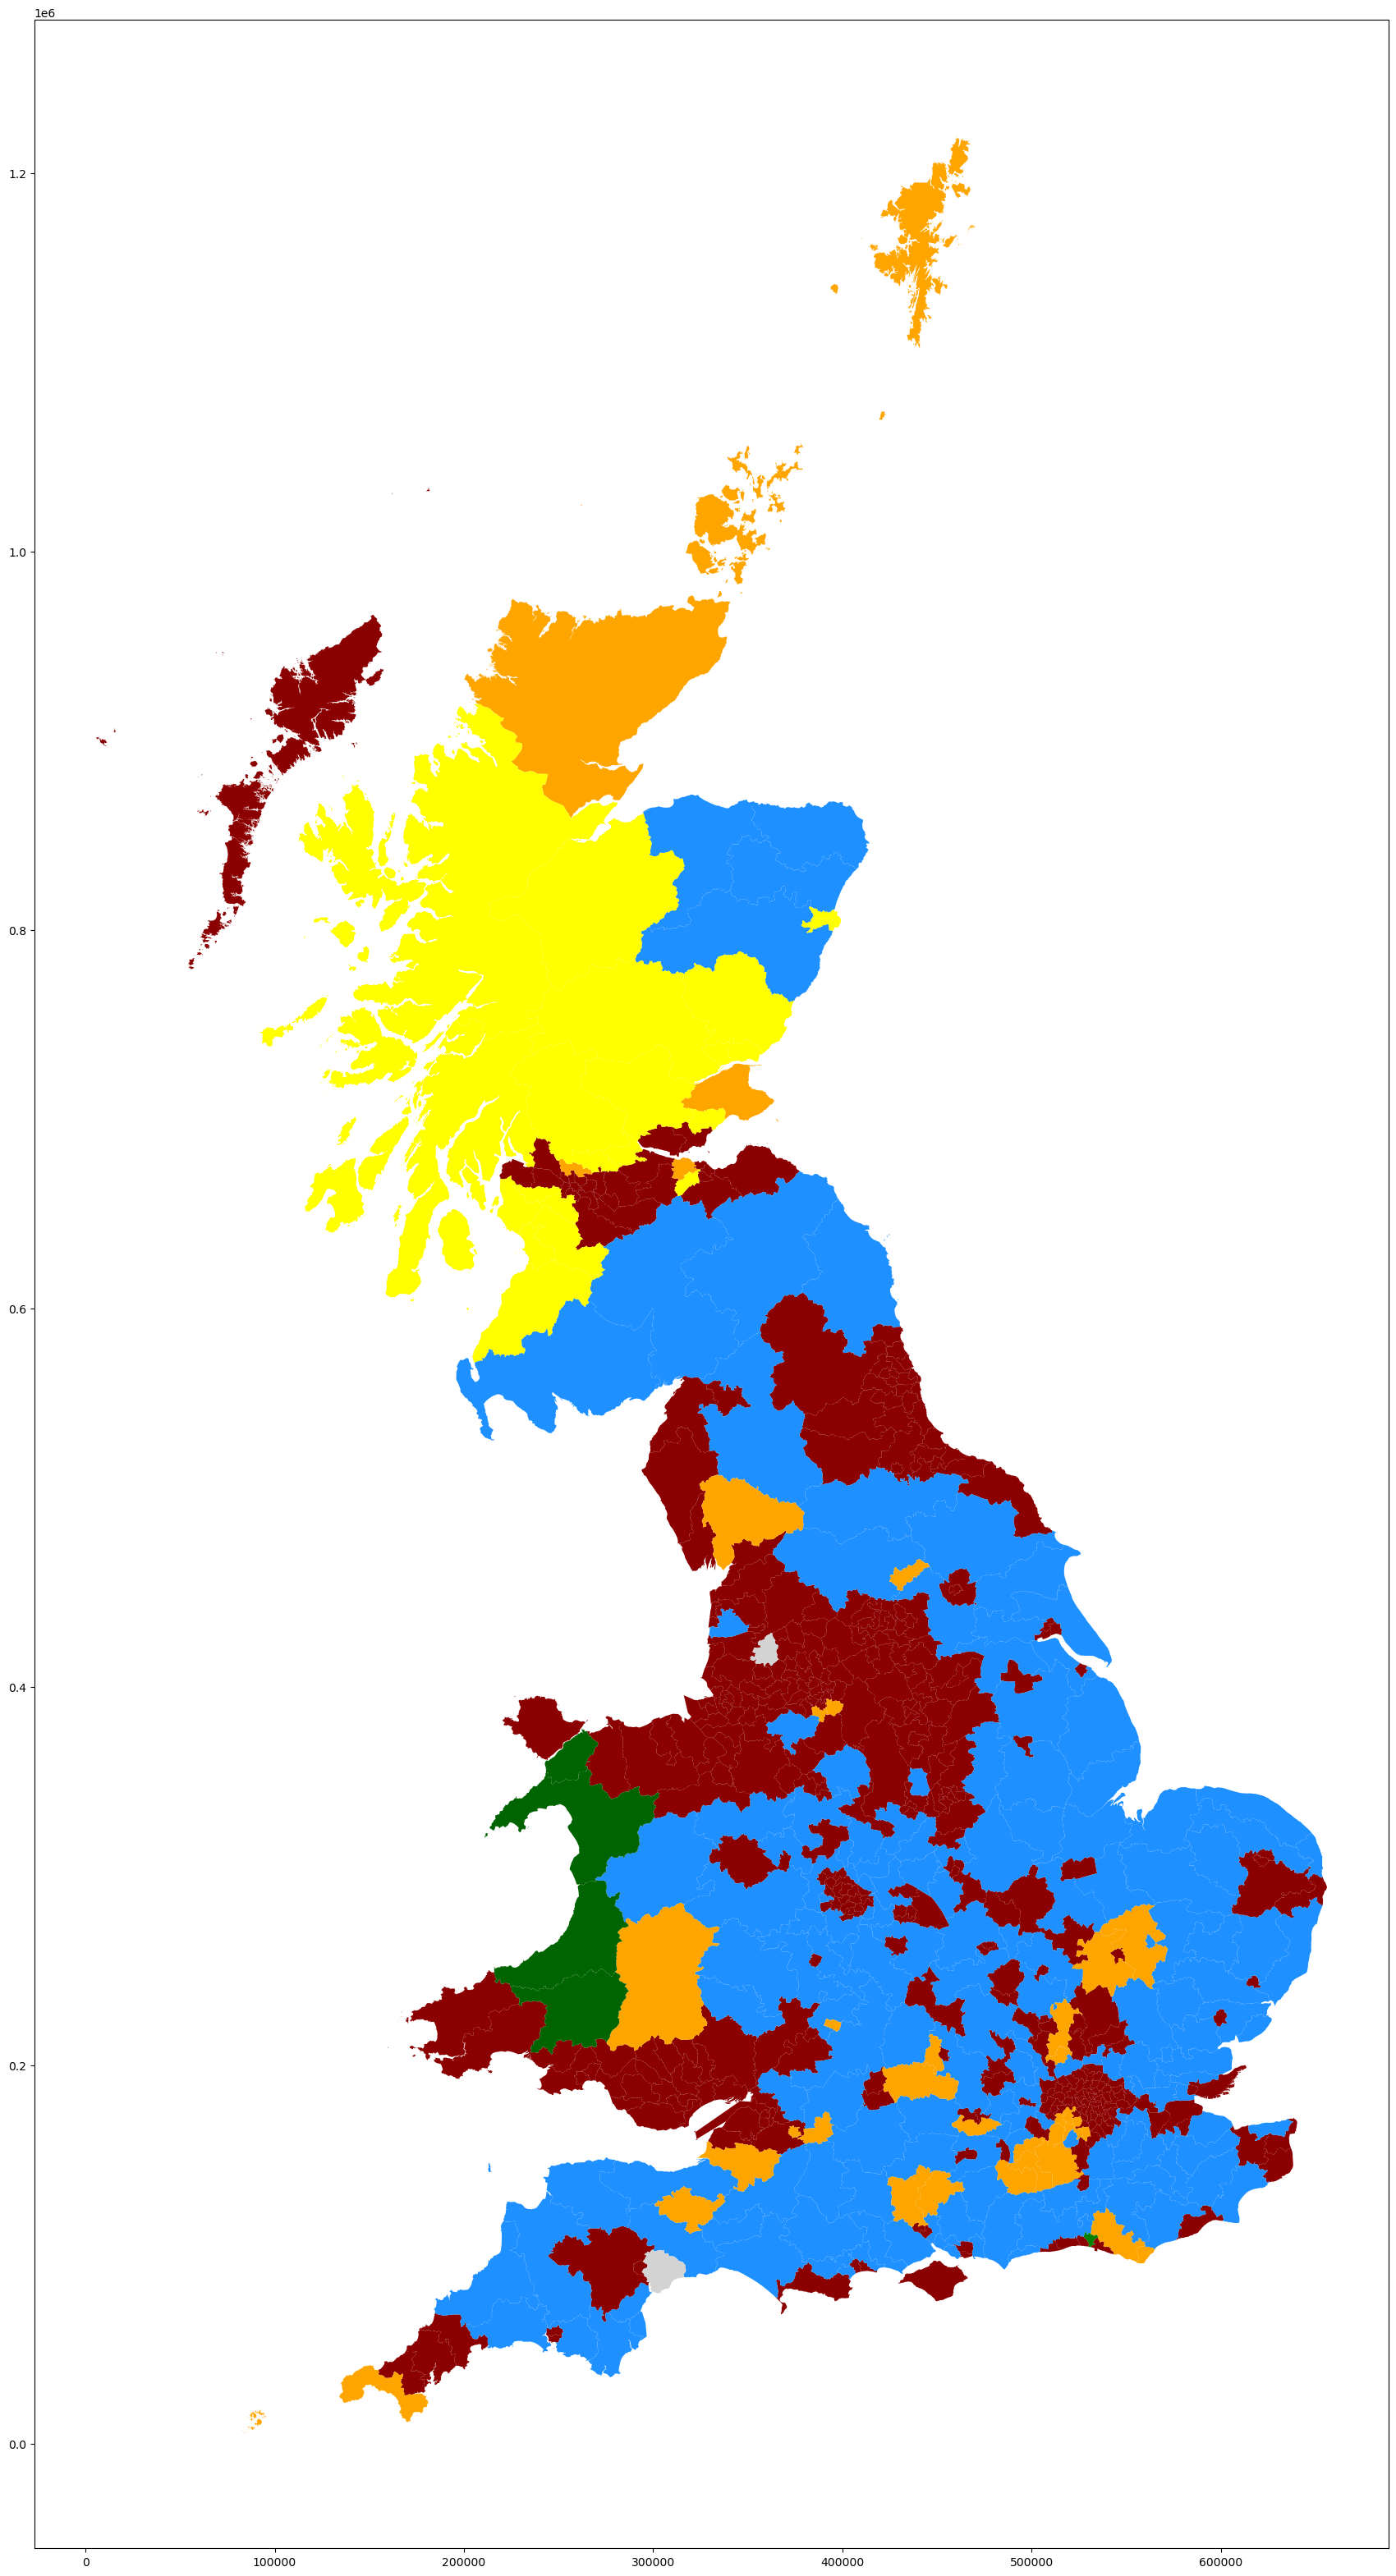

In [6]:
ax2 = predictions_df.plot(figsize=(40,40), color="none", edgecolor="none")
seat_winning_parties = list(predictions_df["PREDICTED_WINNER"].unique())
for party in seat_winning_parties:
    predictions_df[predictions_df["PREDICTED_WINNER"] == party].plot(color=party_colors[party], ax=ax2)


In [7]:
predictions_df["PREDICTED_WINNER"].value_counts()

PREDICTED_WINNER
Lab      404
Con      162
LD        38
SNP       21
PC         4
other      2
Green      1
Name: count, dtype: int64

In [8]:
list(predictions_df[(predictions_df["PREDICTED_WINNER"] == "Lab") & (predictions_df["first_party"] == "Con")].index)

['Aldershot',
 'Altrincham and Sale West',
 'Ashfield',
 'Aylesbury',
 'Banbury',
 'Barrow and Furness',
 'Basingstoke',
 'Bassetlaw',
 'Beckenham',
 'Bexleyheath and Crayford',
 'Birmingham, Northfield',
 'Bishop Auckland',
 'Blackpool North and Cleveleys',
 'Blackpool South',
 'Blyth Valley',
 'Bolsover',
 'Bolton North East',
 'Bolton West',
 'Bournemouth East',
 'Bournemouth West',
 'Bromley and Chislehurst',
 'Broxtowe',
 'Burnley',
 'Burton',
 'Bury North',
 'Bury South',
 'Calder Valley',
 'Carlisle',
 'Central Devon',
 'Chelsea and Fulham',
 'Chingford and Woodford Green',
 'Chipping Barnet',
 'Cities Of London and Westminster',
 'Colchester',
 'Colne Valley',
 'Congleton',
 'Copeland',
 'Corby',
 'Crawley',
 'Crewe and Nantwich',
 'Croydon South',
 'Darlington',
 'Derbyshire Dales',
 'Derby North',
 'Dewsbury',
 'Don Valley',
 'Dover',
 'Dudley North',
 'East Worthing and Shoreham',
 'Eddisbury',
 'Elmet and Rothwell',
 'Erewash',
 'Filton and Bradley Stoke',
 'Finchley and Go